In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
df = pd.read_csv('../repo/burnt_labels/test_food_bev_alc.csv')

data_cleaned =df.drop(columns=['link', 'typeID'])

label_split = data_cleaned['label'].str.split('/', expand=True)

label_split.columns = [f'label_part_{i+1}' for i in range(label_split.shape[1])]

data_expanded = pd.concat([data_cleaned.drop(columns=['label']), label_split], axis=1)

data_expanded.head()

,product,label_part_1,label_part_2,label_part_3,label_part_4,label_part_5,label_part_6
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol,beer,ales,amber red ale,None,None
1,"Yuengling Beer, Traditional Lager, 24 Pack12 f...",alcohol,beer,ales,amber red ale,None,None
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol,beer,ales,amber red ale,None,None
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Age...",alcohol,beer,ales,amber red ale,None,None
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol,beer,ales,amber red ale,None,None


<Axes: xlabel='label_part_2'>

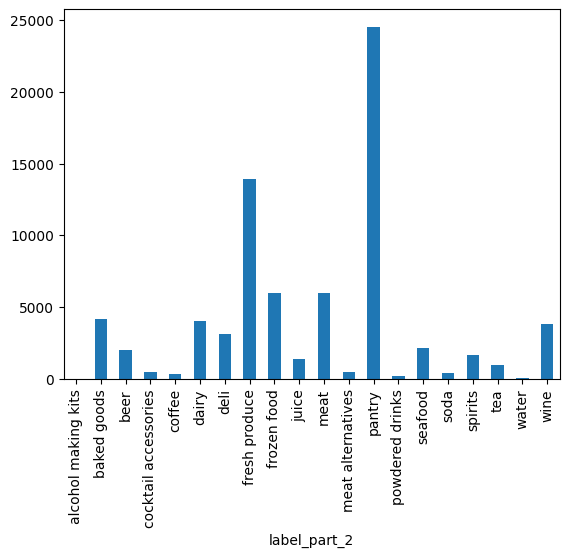

In [5]:
df=data_expanded
df.groupby("label_part_2").size().plot.bar()

In [6]:
unique_labels = df['label_part_2'].unique()
label_to_number = {label: idx for idx, label in enumerate(unique_labels, start=0)}

df['label_part_2_number'] = df['label_part_2'].map(label_to_number)

label_to_number, df.head()


({'beer': 0,
  'alcohol making kits': 1,
  'cocktail accessories': 2,
  'spirits': 3,
  'wine': 4,
  'coffee': 5,
  'juice': 6,
  'powdered drinks': 7,
  'soda': 8,
  'tea': 9,
  'water': 10,
  'deli': 11,
  'baked goods': 12,
  'dairy': 13,
  'meat': 14,
  'seafood': 15,
  'fresh produce': 16,
  'frozen food': 17,
  'meat alternatives': 18,
  'pantry': 19},
                                              product label_part_1  \
 0           New Belgium Brewing Fat Tire Ale12 fl oz      alcohol   
 1  Yuengling Beer, Traditional Lager, 24 Pack12 f...      alcohol   
 2      George Killian's Irish Red Lager Beer12 fl oz      alcohol   
 3  Dragon's Milk Crimson Keep, Bourbon Barrel-Age...      alcohol   
 4                 Smithwick's Red Ale Beer14.9 fl oz      alcohol   
 
   label_part_2 label_part_3   label_part_4 label_part_5 label_part_6  \
 0         beer         ales  amber red ale         None         None   
 1         beer         ales  amber red ale         None         None  

In [7]:
df.tail(100)

,product,label_part_1,label_part_2,label_part_3,label_part_4,label_part_5,label_part_6,label_part_2_number
75843,Bonafide Provisions Organic Beef Bone Broth16....,food,pantry,soups,broths stocks,bone broth,None,19
75844,"Dr. Kellyann Bone Broth, Classic Chicken, Low ...",food,pantry,soups,broths stocks,bone broth,None,19
75845,Pacific Foods Chicken Bone Broth With Lemon Ba...,food,pantry,soups,broths stocks,bone broth,None,19
75846,Dr. Kellyann French Onion Bone Broth16.9 fl oz,food,pantry,soups,broths stocks,bone broth,None,19
75847,Pacific Foods Organic Low Sodium Vegetable Bro...,food,pantry,soups,broths stocks,vegetable broth,None,19
...,...,...,...,...,...,...,...,...
75938,Culinary Tours Miso Broth32 oz,food,pantry,soups,broths stocks,other broths,None,19
75939,"PlantStrong Broth, Organic, Sweet Corn16.9 fl oz",food,pantry,soups,broths stocks,other broths,None,19
75940,Gfs - Gordon Food Service Cream Soup Base28 oz,food,pantry,soups,broths stocks,other broths,None,19
75941,Tsuki Spicy Crab Miso Ramen Base16.9 fl oz,food,pantry,soups,broths stocks,other broths,None,19


In [8]:
num_classes = len(df['label_part_2_number'].unique())
print(f"Number of unique classes: {num_classes}")


Number of unique classes: 20


In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = label_to_number

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label_part_2']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['product']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

/Users/physics2/Desktop/Archive/playground/erdos/.erdos/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

60754 7594 7595


/Users/physics2/Desktop/Archive/playground/erdos/.erdos/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
class GPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(GPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [30]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = GPT2SequenceClassifier(hidden_size=768, num_classes=num_classes, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 30377/30377 [7:41:01<00:00,  1.10it/s]     


Epochs: 1 | Train Loss:  0.880             | Train Accuracy:  0.484             | Val Loss:  0.658             | Val Accuracy:  0.593


In [60]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.575


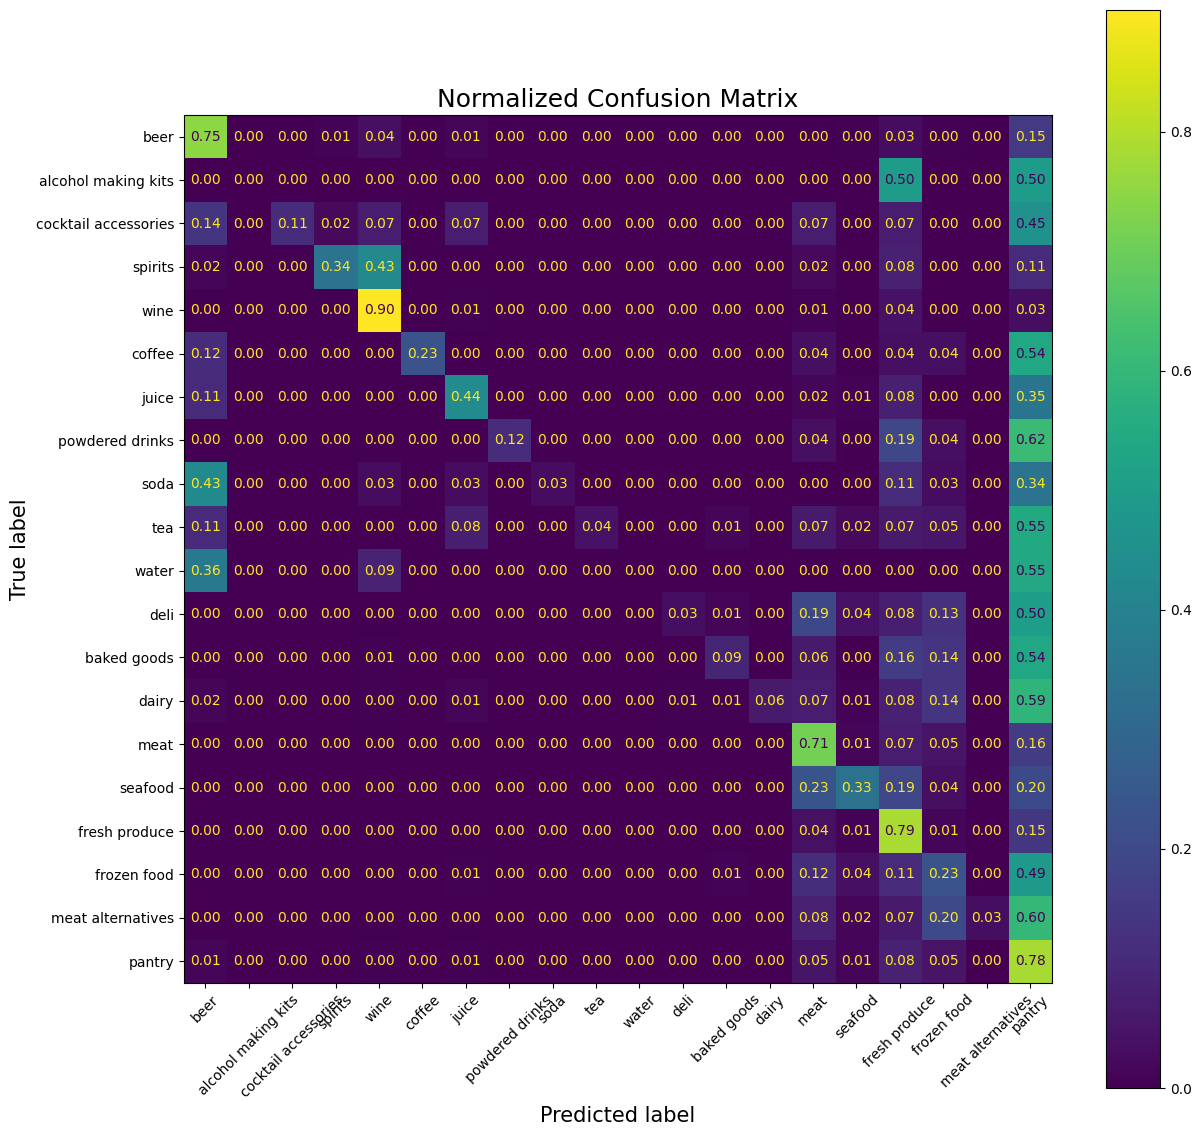

In [85]:
fig, ax = plt.subplots(figsize=(14, 14)) 

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f') 

ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title("Normalized Confusion Matrix", fontsize=18)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)

plt.show()

In [34]:
torch.save(model.state_dict(), "my_saved_model.pt")

In [12]:
model_new = GPT2SequenceClassifier(hidden_size=768, num_classes=num_classes, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("my_saved_model.pt"))
model_new.eval()

/var/folders/yn/x5znjqg112sdpx213prg5gzr0000gp/T/ipykernel_19489/4274650278.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load("my_save

GPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=98304, out_features=20, bias=True)
)

In [13]:
example_input = "Karl Strauss Brewing Company Ale12 fl oz"
fixed_text = " ".join(example_input.lower().split())

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)
prob = torch.nn.functional.softmax(output, dim=1)[0]
number_to_label = {v: k for k, v in label_to_number.items()}

# Get predicted label name
pred_label = number_to_label[output.argmax(dim=1).item()]
print(f"Predicted label: {pred_label}")

Predicted label: beer


In [91]:
df.iloc[22]

product                Karl Strauss Brewing Company Ale12 fl oz
label_part_1                                            alcohol
label_part_2                                               beer
label_part_3                                               ales
label_part_4                                      amber red ale
label_part_5                                               None
label_part_6                                               None
label_part_2_number                                           0
Name: 22, dtype: object